In [8]:
!pip install -r requirements.txt

from IPython.display import clear_output
clear_output(wait=False)

In [9]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

#### Evaluating a learning algorithm (Polynomial Regression)

In [10]:
# Splitting the dataset
# Generate some data
from random import random


X,y,x_ideal,y_ideal = gen_data(18,2,0.7)
print('X.shape', X.shape, 'y.shape', y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


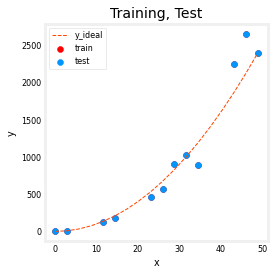

In [11]:
# PLot train, test sets
fig, ax =  plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, '--', color = 'orangered', label='y_ideal', lw=1)
ax.set_title('Training, Test', fontsize=14)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.scatter(X_train, y_train, color='red', label='train')
ax.scatter(X_train, y_train, color=dlc['dlblue'], label='test')
ax.legend(loc='upper left')
plt.show()

In [13]:
# Error calculation for model evaluation, linear regression
def eval_mse(y, yhat):
    m = len(y)
    err = 0.0
    for i in range(m):
        err += (yhat[i] - y[i])**2
    err = err/(2*m)
    return(err)

In [15]:
# Compare performance on training and test data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

In [16]:
print(f'training err {err_train:0.2f}, test err {err_test:0.2f}')

training err 58.01, test err 171215.01


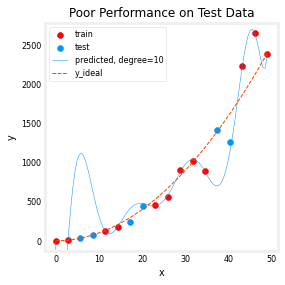

In [17]:
# Plot predictions over data range
x = np.linspace(0, int(X.max()), 100)
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The plot above just showed the model is overfitting and has high variance.

In [18]:
# Let's generate another one with three datasets (train, cross_validation and test)

# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


### Bias and variance

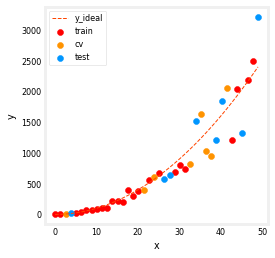

In [19]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(x_ideal, y_ideal, '--', color='orangered', label='y_ideal', lw=1)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

In [20]:
# Finding the optimal degree
max_degree = 9
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100,max_degree))

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:, degree] = lmodel.predict(x)

optimal_degree = np.argmin(err_cv) + 1

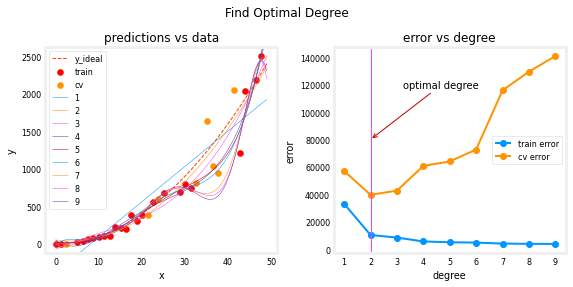

In [21]:
# Plot the result
plt.close('all')
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

In [22]:
# Tuning regularization
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

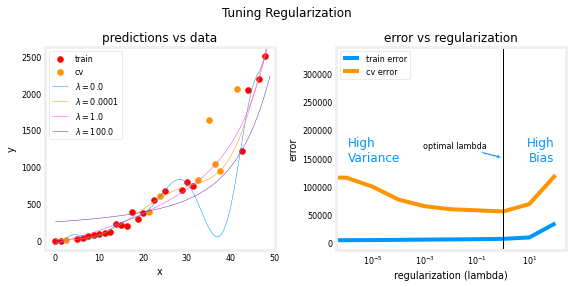

In [23]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

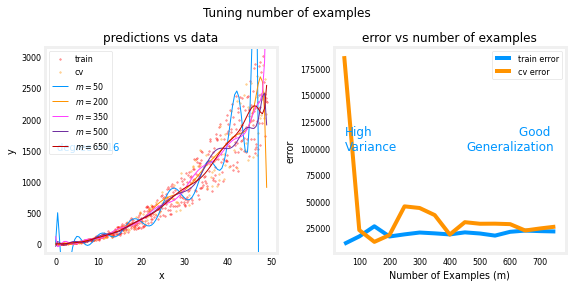

In [24]:
# Getting more data: increasing training size(m)
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

#### Evaluating a learning algorithm (Neural Network)


In [25]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


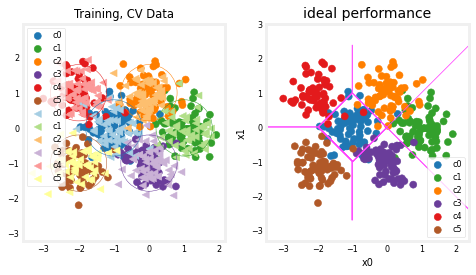

In [26]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

In [27]:
# Evaluating categorical model by calculating classification error
def ecal_cat_err(y,yhat):
    m = len(y)
    incorrect = 0
    for i in range(m):
        if y[i] != yhat[i]:
            incorrect += 1
        else:
            incorrect += 0
    cerr = incorrect/m
    return(cerr)

#### Model Complexity

In [29]:
# Complex model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(units=120, activation='relu'),
        Dense(units=40, activation='relu'),
        Dense(units=6, activation='linear')
  
    ], name="Complex"
)
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
)

2022-07-18 00:31:18.996191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 00:31:19.071304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 00:31:19.071699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 00:31:19.072231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [32]:
model.fit(
    X_train, y_train,
    epochs=1000
)

clear_output(wait=False)

In [33]:
model.summary()

model_test(model, classes, X_train.shape[1]) 

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               360       
                                                                 
 dense_1 (Dense)             (None, 40)                4840      
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
All tests passed!


1082/1082 [==============================] - 1s 638us/step


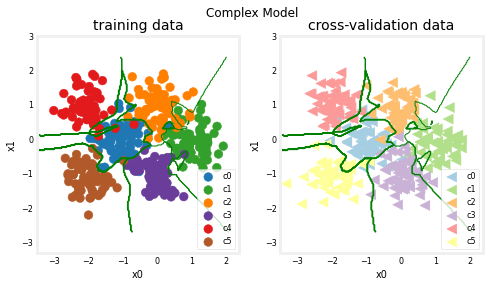

In [34]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

In [35]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 751us/step
categorization error, training, complex model: 0.028
categorization error, cv,       complex model: 0.116


In [36]:
# Simple model
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(units=6, activation='relu'),
        Dense(units=6, activation='linear')
    ], name = "Simple"
)
model_s.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
)

In [37]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)

clear_output(wait=False)

In [38]:
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6)                 18        
                                                                 
 dense_4 (Dense)             (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


1082/1082 [==============================] - 0s 441us/step


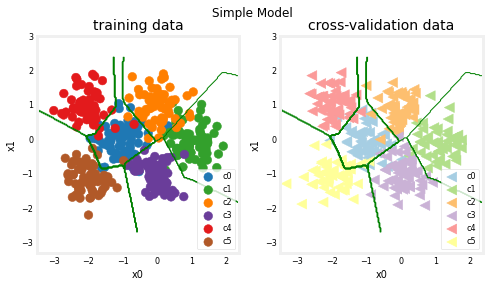

In [39]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

In [40]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 640us/step
categorization error, training, simple model, 0.062, complex model: 0.028
categorization error, cv,       simple model, 0.087, complex model: 0.116


#### Regularization

In [41]:
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(units=120, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units=40, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units=6, activation='linear')
    ], name= 'model_r'
)
model_r.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
)


In [42]:
model_r.fit(
    X_train, y_train,
    epochs=1000
)

clear_output(wait=False)

In [43]:
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 

Model: "model_r"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 120)               360       
                                                                 
 dense_6 (Dense)             (None, 40)                4840      
                                                                 
 dense_7 (Dense)             (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


1082/1082 [==============================] - 0s 450us/step


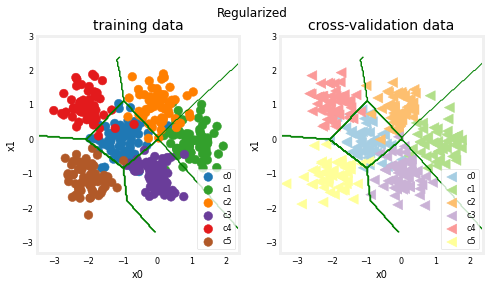

In [44]:
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

In [45]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 742us/step
categorization error, training, regularized: 0.072, simple model, 0.062, complex model: 0.028
categorization error, cv,       regularized: 0.066, simple model, 0.087, complex model: 0.116


#### Iterate to find optimal regularization value

In [47]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None]*len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] = Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )
    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f'Finished lambda = {lambda_}')

    clear_output(wait=False)


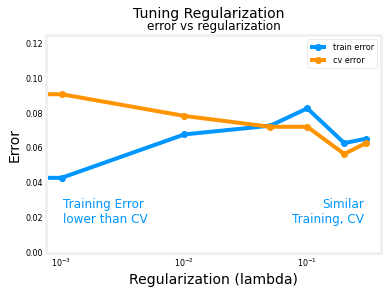

In [48]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)